In [1]:
# Python modules.
import os
import sys
sys.path.insert(0, "..")
sys.path.insert(0, "../data")


# Other modules.
from dotenv import load_dotenv
load_dotenv(dotenv_path=".env", override=True)
import numpy as np
import pandas as pd
from sklearn.metrics import (
    root_mean_squared_error,
    mean_squared_error,
)


# Library.
from src.utils import (
    make_a_sound,
    prepare_submission,
    submit_file,
    get_submission_scores,
)
from src.eda import (
    distplot,
    correlation_heatmap,
    compare_predictions_and_real_values,
    vizualize_feature_importance,
    vizualise_residual,
)
from src.preprocessing import (
    fill_df_navalues,
    scale_and_encoder_features,
    encode_categories_using_encoders_and_scalers,
    split_X_y_in_train_test_sets,
    create_polynomial_features,
    generate_polynomial_column_using_polynomial_feature_encoder,
)
from src.model import (
    get_linear_regression_model,
    get_random_forest_model,
    get_xgboost_model,
    run_grid_search_and_kfold,
)

In [2]:
# Loading data
df_train = (
    pd.concat([
    pd.read_csv("data/train.csv"),
    pd.read_csv("data/training_extra.csv"),
    ])
)

print(df_train.shape)
df_test = pd.read_csv("data/test.csv")

(3994318, 11)


In [3]:
df_train

,id,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price
0,0,Jansport,Leather,Medium,7.0,Yes,No,Tote,Black,11.611723,112.15875
1,1,Jansport,Canvas,Small,10.0,Yes,Yes,Messenger,Green,27.078537,68.88056
2,2,Under Armour,Leather,Small,2.0,Yes,No,Messenger,Red,16.643760,39.17320
3,3,Nike,Nylon,Small,8.0,Yes,No,Messenger,Green,12.937220,80.60793
4,4,Adidas,Canvas,Medium,1.0,Yes,Yes,Messenger,Green,17.749338,86.02312
...,...,...,...,...,...,...,...,...,...,...,...
3694313,4194313,Nike,Canvas,NaN,3.0,Yes,Yes,Messenger,Blue,28.098120,104.74460
3694314,4194314,Puma,Leather,Small,10.0,Yes,Yes,Tote,Blue,17.379531,122.39043
3694315,4194315,Jansport,Canvas,Large,10.0,No,No,Backpack,Red,17.037708,148.18470
3694316,4194316,Puma,Canvas,NaN,2.0,No,No,Backpack,Gray,28.783339,22.32269


### EDA

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3994318 entries, 0 to 3694317
Data columns (total 11 columns):
 #   Column                Dtype  
---  ------                -----  
 0   id                    int64  
 1   Brand                 object 
 2   Material              object 
 3   Size                  object 
 4   Compartments          float64
 5   Laptop Compartment    object 
 6   Waterproof            object 
 7   Style                 object 
 8   Color                 object 
 9   Weight Capacity (kg)  float64
 10  Price                 float64
dtypes: float64(3), int64(1), object(7)
memory usage: 365.7+ MB


In [5]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 10 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    200000 non-null  int64  
 1   Brand                 193773 non-null  object 
 2   Material              194387 non-null  object 
 3   Size                  195619 non-null  object 
 4   Compartments          200000 non-null  float64
 5   Laptop Compartment    195038 non-null  object 
 6   Waterproof            195189 non-null  object 
 7   Style                 194847 non-null  object 
 8   Color                 193215 non-null  object 
 9   Weight Capacity (kg)  199923 non-null  float64
dtypes: float64(2), int64(1), object(7)
memory usage: 15.3+ MB


<Figure size 1900x1000 with 0 Axes>

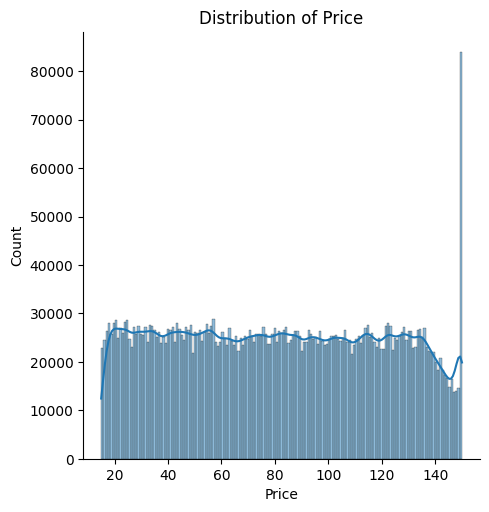

<Figure size 1900x1000 with 0 Axes>

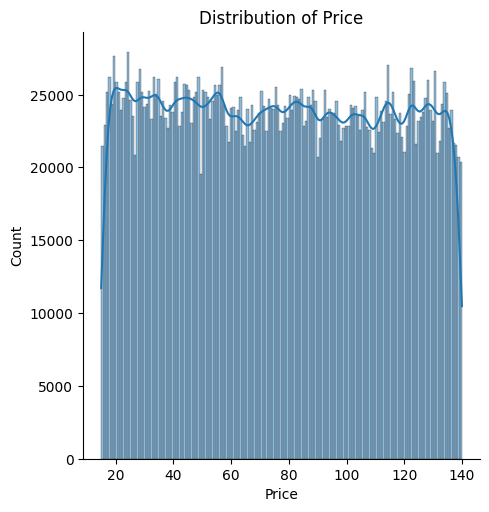

In [6]:
distplot(df=df_train, variable_name="Price")
df_train = df_train.drop(df_train[df_train.Price >= 140].index)
distplot(df=df_train, variable_name="Price")

In [7]:
# quan = QuantileTransformer(output_distribution="normal", n_quantiles=200)
# df_train["log_Price"] = np.log1p(df_train.Price)
# distplot(df=df_train, variable_name="log_Price")
# df_train["reverse_log_Price"] = np.expm1(df_train.log_Price)
# distplot(df=df_train, variable_name="reverse_log_Price")

## Preprocessing

In [8]:
# Preprocessing
df_train_filled = fill_df_navalues(df=df_train)
df_train_filled.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3692505 entries, 0 to 3694317
Data columns (total 11 columns):
 #   Column                Dtype  
---  ------                -----  
 0   id                    int64  
 1   Brand                 object 
 2   Material              object 
 3   Size                  object 
 4   Compartments          float64
 5   Laptop Compartment    object 
 6   Waterproof            object 
 7   Style                 object 
 8   Color                 object 
 9   Weight Capacity (kg)  float64
 10  Price                 float64
dtypes: float64(3), int64(1), object(7)
memory usage: 467.1+ MB


## Creating new features

In [9]:
def find_weight_group(x):
    if x <= 7:
        return "Low Low"
    elif (x > 7) & (x <= 15):
        return "Low"
    elif (x > 15) & (x <= 22):
        return "Low Medium"
    elif (x > 22) & (x <= 30):
        return "Medium"
    elif (x > 30) & (x <= 37):
        return "Medium"
    else:
        return "High"


def find_compartment_group(x):
    if x <= 3:
        return "Low"
    elif (x > 3) & (x <= 5):
        return "Medium"
    elif (x > 5) & (x <= 7):
        return "Medium Plus"
    elif x > 7:
        return "High"


def find_style(x):
    if x in ["Under Armour", "Nike"]:
        return "Street Wear"
    elif x == "Jansport":
        return "Casual"
    elif x in ["Adidas", "Puma"]:
        return "Fancy Street Wear"


def find_material_price(x):
    if x in ["Leather"]:
        return "Expensive"
    elif x in ["Canvas", "Nylon"]:
        return "Medium"
    elif x in ["Polyester"]:
        return "Cheap"


def create_new_features(input_df: pd.DataFrame) -> pd.DataFrame:
    """Create variables using deduction and previous variables.
    Creating categories basically.

    :param input_df:
    :return pd.DataFrame:
    """
    output_df = input_df.copy()
    output_df["Weight Group"] = output_df["Weight Capacity (kg)"].apply(
        lambda x: find_weight_group(x)
    )
    output_df["Compartments"] = output_df.Compartments.astype("category")
    output_df["Compartement Group"] = output_df["Compartments"].apply(
        lambda x: find_compartment_group(x)
    )
    output_df["Brand Style"] = output_df["Brand"].apply(lambda x: find_style(x))
    output_df["Material Category"] = output_df["Material"].apply(lambda x: find_material_price(x))
    # output_df["Weight capacity 2"] = output_df["Weight Capacity (kg)"] ** 2
    return output_df


df_train_filled = create_new_features(input_df=df_train_filled)
df_train_filled.info()


<class 'pandas.core.frame.DataFrame'>
Index: 3692505 entries, 0 to 3694317
Data columns (total 15 columns):
 #   Column                Dtype   
---  ------                -----   
 0   id                    int64   
 1   Brand                 object  
 2   Material              object  
 3   Size                  object  
 4   Compartments          category
 5   Laptop Compartment    object  
 6   Waterproof            object  
 7   Style                 object  
 8   Color                 object  
 9   Weight Capacity (kg)  float64 
 10  Price                 float64 
 11  Weight Group          object  
 12  Compartement Group    object  
 13  Brand Style           object  
 14  Material Category     object  
dtypes: category(1), float64(2), int64(1), object(11)
memory usage: 555.1+ MB


In [10]:
df_train_filled

,id,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price,Weight Group,Compartement Group,Brand Style,Material Category
0,0,Jansport,Leather,Medium,7.0,Yes,No,Tote,Black,11.611723,112.15875,Low,Medium Plus,Casual,Expensive
1,1,Jansport,Canvas,Small,10.0,Yes,Yes,Messenger,Green,27.078537,68.88056,Medium,High,Casual,Medium
2,2,Under Armour,Leather,Small,2.0,Yes,No,Messenger,Red,16.643760,39.17320,Low Medium,Low,Street Wear,Expensive
3,3,Nike,Nylon,Small,8.0,Yes,No,Messenger,Green,12.937220,80.60793,Low,High,Street Wear,Medium
4,4,Adidas,Canvas,Medium,1.0,Yes,Yes,Messenger,Green,17.749338,86.02312,Low Medium,Low,Fancy Street Wear,Medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3694312,4194312,Jansport,Polyester,Large,6.0,Yes,Yes,Backpack,Red,16.641739,31.52978,Low Medium,Medium Plus,Casual,Cheap
3694313,4194313,Nike,Canvas,Medium,3.0,Yes,Yes,Messenger,Blue,28.098120,104.74460,Medium,Low,Street Wear,Medium
3694314,4194314,Puma,Leather,Small,10.0,Yes,Yes,Tote,Blue,17.379531,122.39043,Low Medium,High,Fancy Street Wear,Expensive
3694316,4194316,Puma,Canvas,Medium,2.0,No,No,Backpack,Gray,28.783339,22.32269,Medium,Low,Fancy Street Wear,Medium


In [47]:
df_polynomial_transform, pf = create_polynomial_features(df=df_train_filled.loc[:, ["id", "Weight Capacity (kg)"]], polynomial_degree=2)
df_polynomial_transform

,id,Original,polynomial_1
0,0,11.611723,134.832107
1,1,27.078537,733.247143
2,2,16.643760,277.014745
3,3,12.937220,167.371669
4,4,17.749338,315.039016
...,...,...,...
3692500,4194312,16.641739,276.947468
3692501,4194313,28.098120,789.504350
3692502,4194314,17.379531,302.048098
3692503,4194316,28.783339,828.480619


In [48]:
df_train_filled = pd.merge(
    df_train_filled,
    df_polynomial_transform,
    on="id",
    how="left",
).drop(columns=["Original"])
df_train_filled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3692505 entries, 0 to 3692504
Data columns (total 16 columns):
 #   Column                Dtype   
---  ------                -----   
 0   id                    int64   
 1   Brand                 object  
 2   Material              object  
 3   Size                  object  
 4   Compartments          category
 5   Laptop Compartment    object  
 6   Waterproof            object  
 7   Style                 object  
 8   Color                 object  
 9   Weight Capacity (kg)  float64 
 10  Price                 float64 
 11  Weight Group          object  
 12  Compartement Group    object  
 13  Brand Style           object  
 14  Material Category     object  
 15  polynomial_1          float64 
dtypes: category(1), float64(3), int64(1), object(11)
memory usage: 426.1+ MB


In [11]:
# Scaling
df_train_filled_n, scalers_and_encoders = scale_and_encoder_features(df=df_train_filled)
df_train_filled_n.info()


<class 'pandas.core.frame.DataFrame'>
Index: 3692505 entries, 0 to 3694317
Data columns (total 15 columns):
 #   Column                Dtype   
---  ------                -----   
 0   id                    int64   
 1   Brand                 category
 2   Material              category
 3   Size                  category
 4   Compartments          category
 5   Laptop Compartment    category
 6   Waterproof            category
 7   Style                 category
 8   Color                 category
 9   Weight Capacity (kg)  float64 
 10  Price                 float64 
 11  Weight Group          category
 12  Compartement Group    category
 13  Brand Style           category
 14  Material Category     category
dtypes: category(12), float64(2), int64(1)
memory usage: 283.9 MB


In [12]:
df_train_filled_n

,id,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price,Weight Group,Compartement Group,Brand Style,Material Category
0,0,1,1,1,6,1,0,2,0,-0.915261,0.979383,0,3,0,1
1,1,1,0,2,9,1,1,1,3,1.301691,-0.218570,3,0,0,2
2,2,4,1,2,1,1,0,1,5,-0.193989,-1.040878,2,1,2,1
3,3,2,2,2,7,1,0,1,3,-0.725270,0.106047,0,0,2,2
4,4,0,0,1,0,1,1,1,3,-0.035519,0.255941,2,1,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3694312,4194312,1,3,0,5,1,1,0,5,-0.194278,-1.252450,2,3,0,0
3694313,4194313,2,0,1,2,1,1,1,1,1.447834,0.774157,3,1,2,2
3694314,4194314,3,1,2,9,1,1,2,1,-0.088526,1.262599,2,0,1,1
3694316,4194316,3,0,1,1,0,0,0,2,1.546051,-1.507305,3,1,1,2


### Correlation matrix.

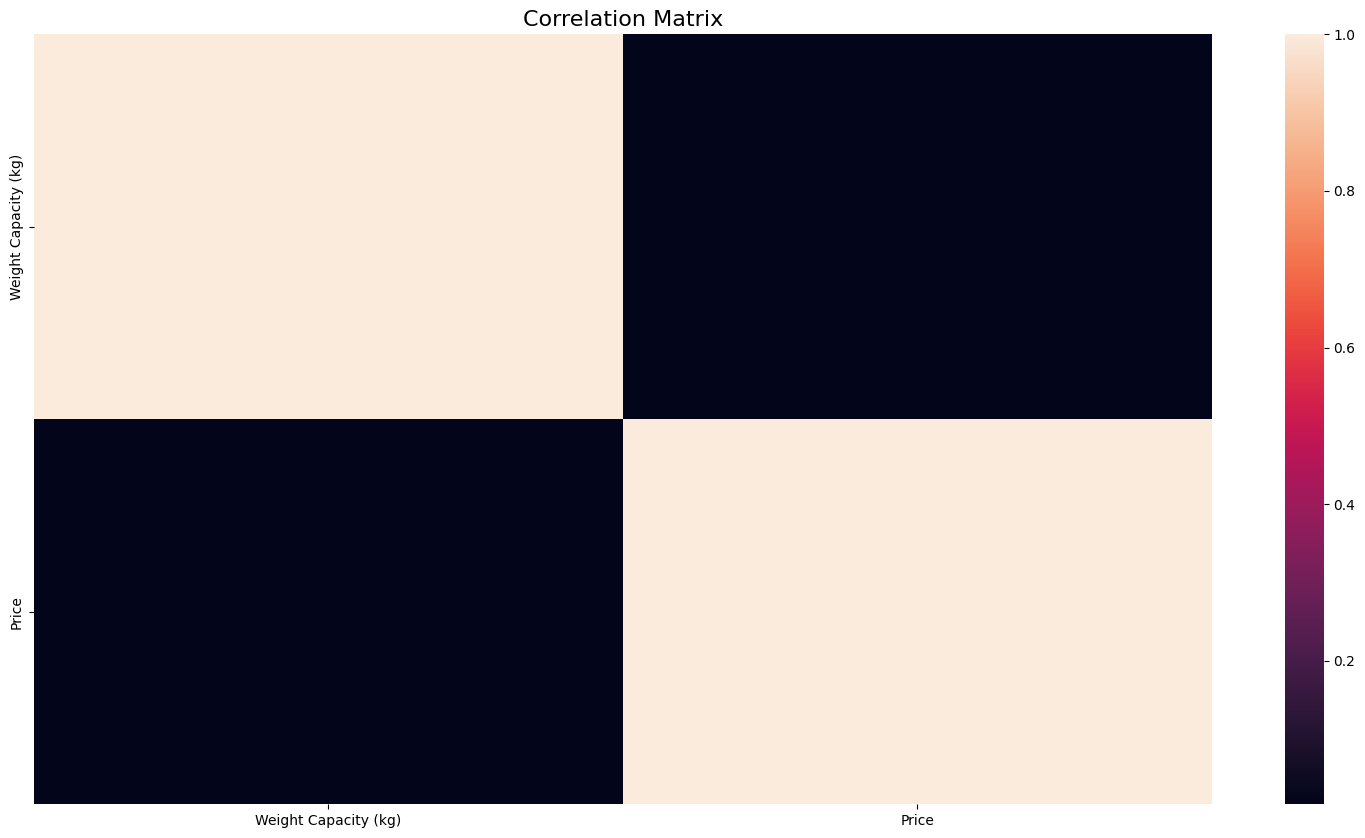

In [13]:
corr = (
    df_train_filled_n
    .select_dtypes(include=["float64", "int64"])
    .drop(columns=["id", "index"], errors='ignore')
    .corr()
)
correlation_heatmap(df_correlation=corr)

In [14]:
column_names = df_train_filled_n.drop(columns=["Price", "log_Price", "index", "id"], errors="ignore").columns
X = df_train_filled_n.loc[:, column_names]
y = df_train_filled_n.loc[:, ["Price"]]
X_train, X_test, y_train, y_test = split_X_y_in_train_test_sets(X=X, y=y)

In [17]:
best_model, parameters = get_xgboost_model()
best_model.fit(X_train, y_train)
# best_model = run_grid_search_and_kfold(
#     model=best_model,
#     parameters=parameters,
#     X_train=X_train,
#     y_train=y_train,  # .ravel() to fix warnings?
# )
make_a_sound()

ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, the experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:Brand: category, Material: category, Size: category, Compartments: category, Laptop Compartment: category, Waterproof: category, Style: category, Color: category, Weight Group: category, Compartement Group: category, Brand Style: category, Material Category: category

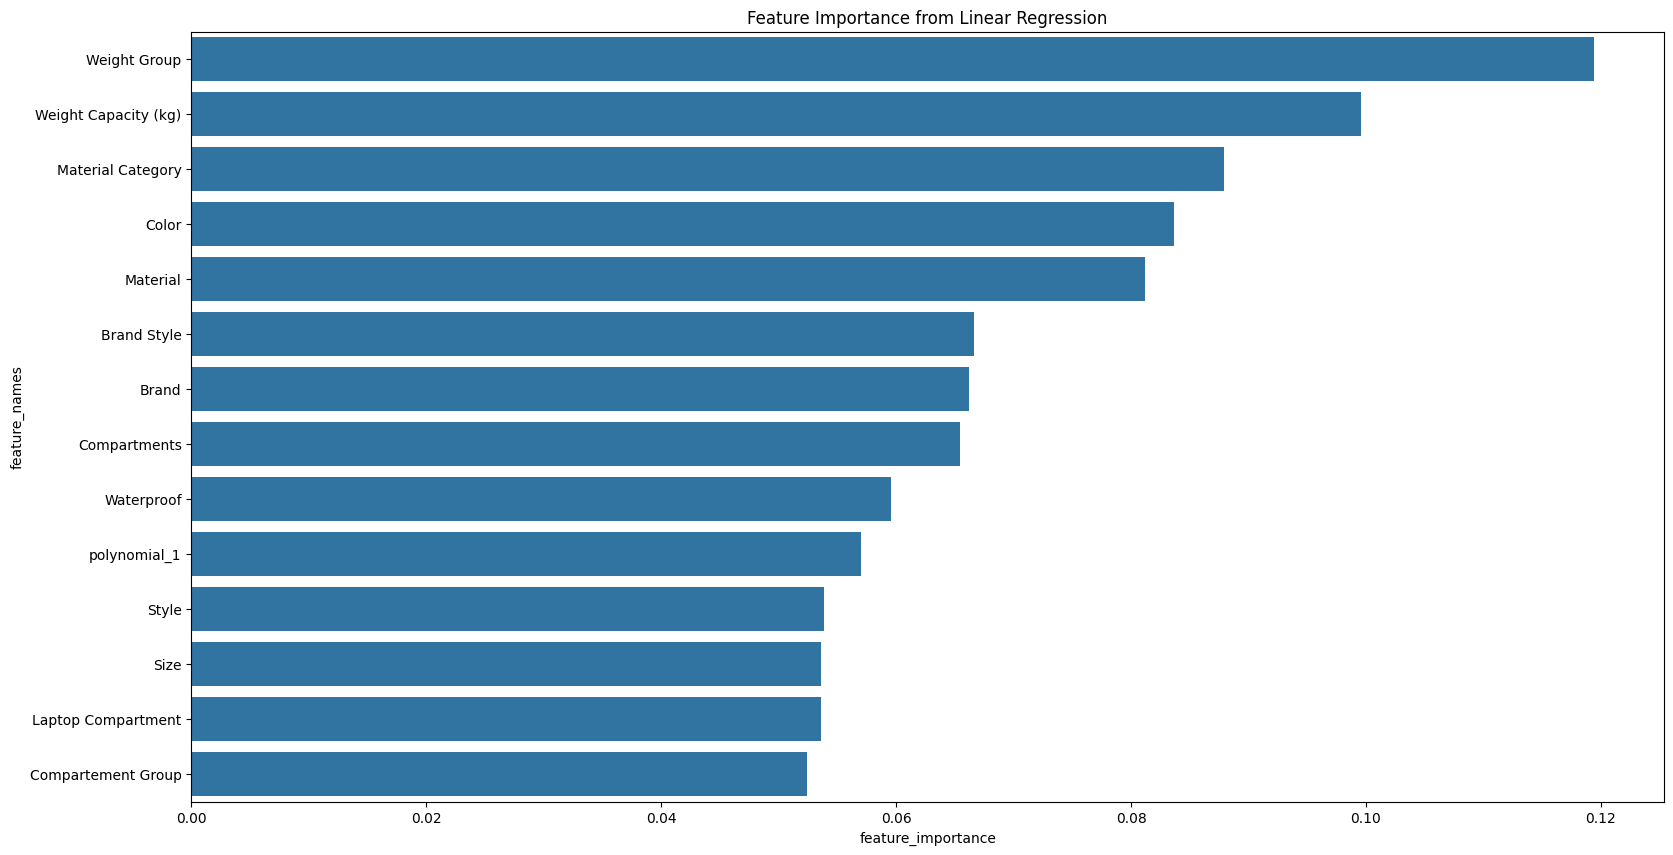

In [54]:
vizualize_feature_importance(
    model=best_model,
    feature_names=column_names,
)

In [55]:
score = best_model.score(X_test, y_test)
mse = mean_squared_error(y_true=y_test, y_pred=best_model.predict(X_test))
# intercept = model.intercept_
# coeff = model.coef_
print(f"Score: {score:.2f}") # vs {score_l:.2f} vs {score_rf:.2f}")
print(f"MSE: {mse:.2f}") # vs {rmse_l:.2f} vs {rmse_rf:.2f}")

Score: 0.00
MSE: 1.00


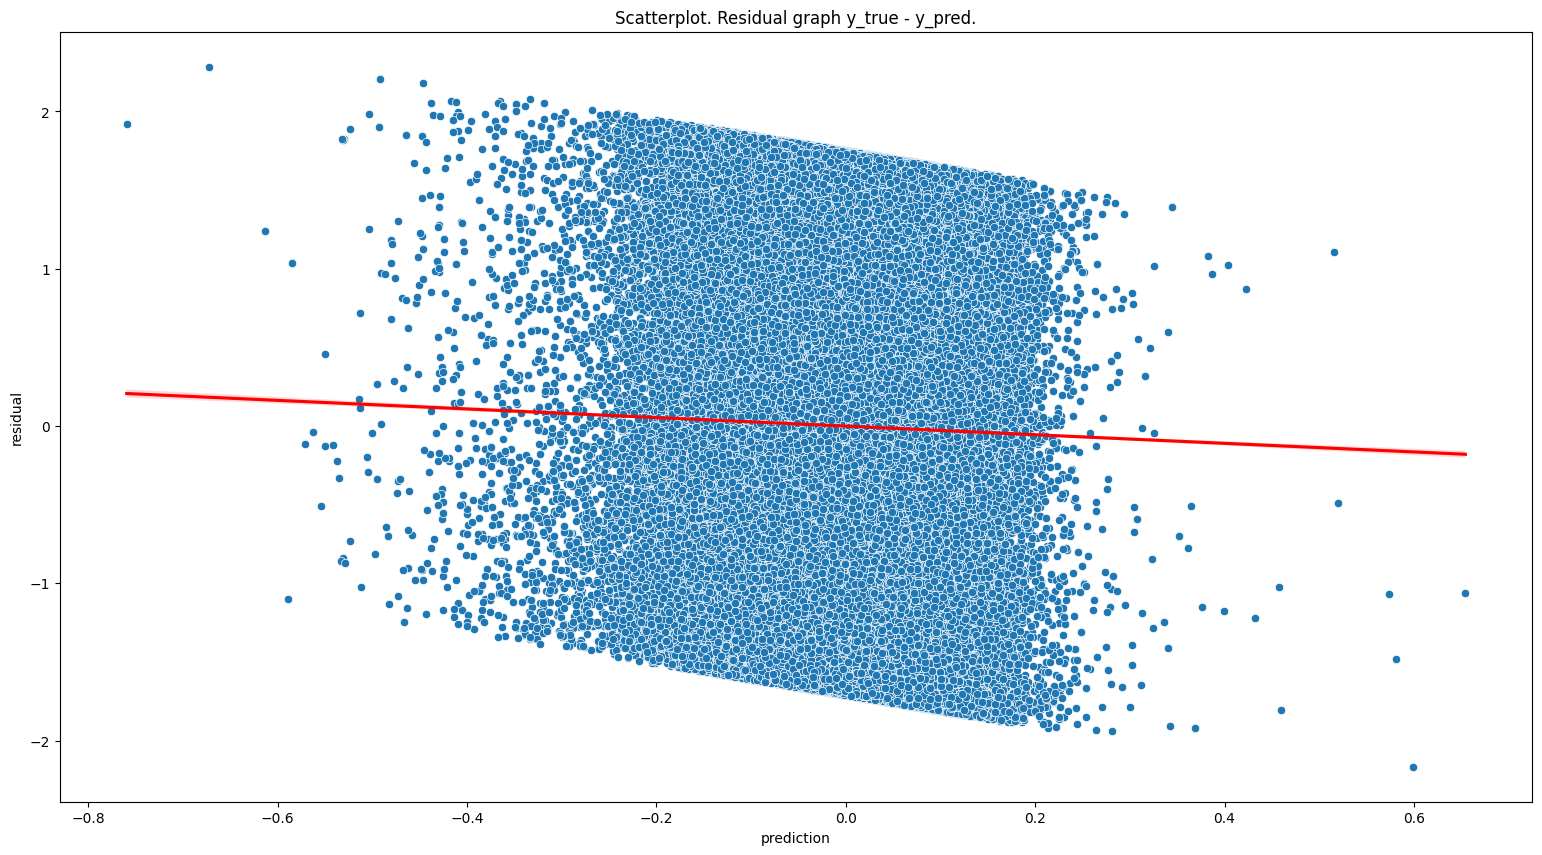

In [56]:
vizualise_residual(
    y_true=y_test["Price"].values,
    y_pred=best_model.predict(X_test[column_names]).reshape(-1),
    subset=1_000_000,
)

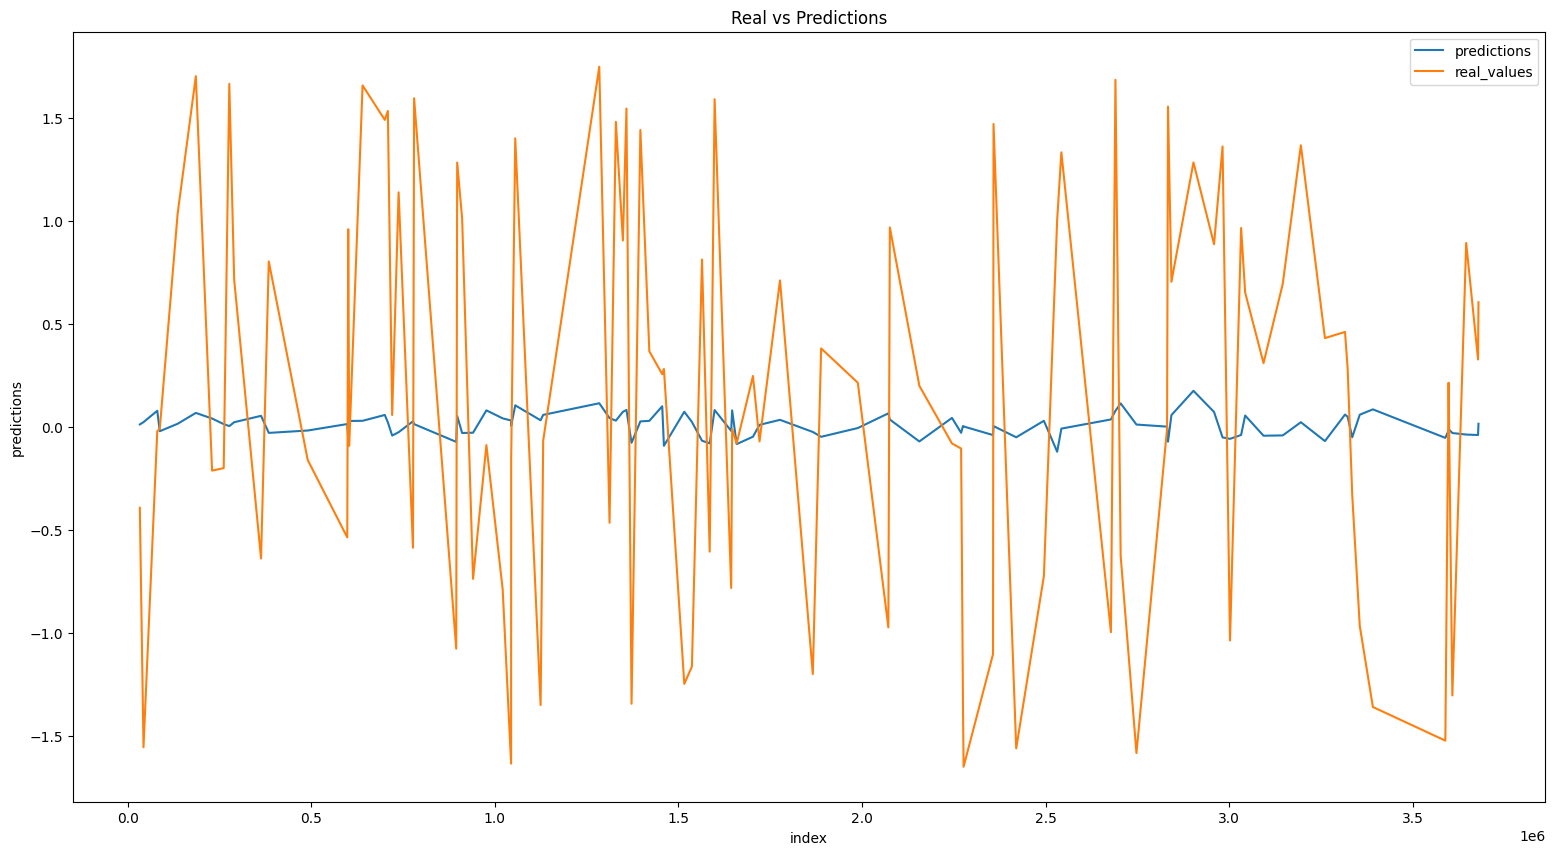

In [57]:
X_test["predictions"] = best_model.predict(X_test[column_names]).reshape(-1)
X_test["real_values"] = y_test.loc[:, ["Price"]]

compare_predictions_and_real_values(
    df=X_test.reset_index().iloc[:100]
)

In [58]:
df_test_filled = fill_df_navalues(df=df_test)
df_test_filled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 10 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    200000 non-null  int64  
 1   Brand                 200000 non-null  object 
 2   Material              200000 non-null  object 
 3   Size                  200000 non-null  object 
 4   Compartments          200000 non-null  float64
 5   Laptop Compartment    200000 non-null  object 
 6   Waterproof            200000 non-null  object 
 7   Style                 200000 non-null  object 
 8   Color                 200000 non-null  object 
 9   Weight Capacity (kg)  200000 non-null  float64
dtypes: float64(2), int64(1), object(7)
memory usage: 15.3+ MB


In [59]:
df_test_filled = create_new_features(input_df=df_test_filled)
df_test_filled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 14 columns):
 #   Column                Non-Null Count   Dtype   
---  ------                --------------   -----   
 0   id                    200000 non-null  int64   
 1   Brand                 200000 non-null  object  
 2   Material              200000 non-null  object  
 3   Size                  200000 non-null  object  
 4   Compartments          200000 non-null  category
 5   Laptop Compartment    200000 non-null  object  
 6   Waterproof            200000 non-null  object  
 7   Style                 200000 non-null  object  
 8   Color                 200000 non-null  object  
 9   Weight Capacity (kg)  200000 non-null  float64 
 10  Weight Group          200000 non-null  object  
 11  Compartement Group    200000 non-null  object  
 12  Brand Style           200000 non-null  object  
 13  Material Category     200000 non-null  object  
dtypes: category(1), float64(1), int64(1)

In [60]:
df_test_filled

,id,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Weight Group,Compartement Group,Brand Style,Material Category
0,300000,Puma,Leather,Small,2.0,No,No,Tote,Green,20.671147,Low Medium,Low,Fancy Street Wear,Expensive
1,300001,Nike,Canvas,Medium,7.0,No,Yes,Backpack,Green,13.564105,Low,Medium Plus,Street Wear,Medium
2,300002,Adidas,Canvas,Large,9.0,No,Yes,Messenger,Blue,11.809799,Low,High,Fancy Street Wear,Medium
3,300003,Adidas,Nylon,Large,1.0,Yes,No,Messenger,Green,18.477036,Low Medium,Low,Fancy Street Wear,Medium
4,300004,Adidas,Nylon,Large,2.0,Yes,Yes,Tote,Black,9.907953,Low,Low,Fancy Street Wear,Medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,499995,Adidas,Canvas,Large,2.0,Yes,No,Messenger,Red,7.383498,Low,Low,Fancy Street Wear,Medium
199996,499996,Nike,Polyester,Small,9.0,No,Yes,Messenger,Pink,6.058394,Low Low,High,Street Wear,Cheap
199997,499997,Jansport,Nylon,Small,9.0,No,Yes,Tote,Green,26.890163,Medium,High,Casual,Medium
199998,499998,Puma,Nylon,Large,10.0,Yes,No,Tote,Gray,25.769153,Medium,High,Fancy Street Wear,Medium


In [61]:
df_test_polynomial = generate_polynomial_column_using_polynomial_feature_encoder(df=df_test_filled.loc[:, ["id", "Weight Capacity (kg)"]], polynomial_encoder=pf)
df_test_filled = pd.merge(
    df_test_filled,
    df_test_polynomial,
    on="id",
    how="left",
).drop(columns=["Original"])
df_train_filled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3692505 entries, 0 to 3692504
Data columns (total 16 columns):
 #   Column                Dtype   
---  ------                -----   
 0   id                    int64   
 1   Brand                 object  
 2   Material              object  
 3   Size                  object  
 4   Compartments          category
 5   Laptop Compartment    object  
 6   Waterproof            object  
 7   Style                 object  
 8   Color                 object  
 9   Weight Capacity (kg)  float64 
 10  Price                 float64 
 11  Weight Group          object  
 12  Compartement Group    object  
 13  Brand Style           object  
 14  Material Category     object  
 15  polynomial_1          float64 
dtypes: category(1), float64(3), int64(1), object(11)
memory usage: 426.1+ MB


In [62]:
df_test_filled_n = encode_categories_using_encoders_and_scalers(df=df_test_filled, encoders_and_scalers=scalers_and_encoders)
df_test_filled_n.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 15 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    200000 non-null  int64  
 1   Brand                 200000 non-null  int64  
 2   Material              200000 non-null  int64  
 3   Size                  200000 non-null  int64  
 4   Compartments          200000 non-null  int64  
 5   Laptop Compartment    200000 non-null  int64  
 6   Waterproof            200000 non-null  int64  
 7   Style                 200000 non-null  int64  
 8   Color                 200000 non-null  int64  
 9   Weight Capacity (kg)  200000 non-null  float64
 10  Weight Group          200000 non-null  int64  
 11  Compartement Group    200000 non-null  int64  
 12  Brand Style           200000 non-null  int64  
 13  Material Category     200000 non-null  int64  
 14  polynomial_1          200000 non-null  float64
dtype

/Users/Baptiste/Documents/swag2-backpack-predict/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/Baptiste/Documents/swag2-backpack-predict/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/Baptiste/Documents/swag2-backpack-predict/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, 

In [63]:
df_test_filled_n["scale_Price_prediction"] = best_model.predict(df_test_filled_n.loc[:, column_names])
df_test_filled_n["Price_prediction"] = scalers_and_encoders["Price"].inverse_transform(df_test_filled_n.loc[:, ["scale_Price_prediction"]])
df_test_filled_n

,id,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Weight Group,Compartement Group,Brand Style,Material Category,polynomial_1,scale_Price_prediction,Price_prediction
0,300000,3,1,2,1,0,0,2,3,0.383281,2,1,1,1,0.216982,-0.009505,76.433388
1,300001,2,0,1,6,0,1,0,3,-0.635414,0,3,2,2,-0.747718,0.075310,79.497505
2,300002,0,0,0,8,0,1,1,1,-0.886870,0,0,1,2,-0.924209,0.066080,79.164040
3,300003,0,2,0,0,1,0,1,3,0.068786,2,1,1,2,-0.123583,-0.035118,75.508072
4,300004,0,2,0,1,1,1,2,0,-1.159473,0,1,1,2,-1.087974,-0.060313,74.597870
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,499995,0,0,0,1,1,0,1,5,-1.521318,0,1,1,2,-1.261047,-0.046996,75.078972
199996,499996,2,3,2,8,0,1,1,4,-1.711254,1,0,2,0,-1.331669,-0.075868,74.035934
199997,499997,1,2,2,8,0,1,2,3,1.274691,3,0,0,2,1.389733,0.023944,77.641808
199998,499998,3,2,0,9,1,0,2,2,1.114009,3,0,1,2,1.155679,0.034443,78.021103


<Figure size 1900x1000 with 0 Axes>

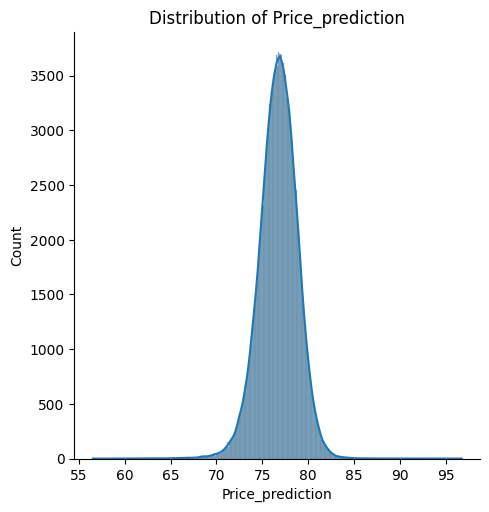

In [64]:
# distplot(df=df_test_filled_n, variable_name="log_Price_prediction")
distplot(df=df_test_filled_n, variable_name="Price_prediction")

In [65]:
prepare_submission(df_predictions=df_test_filled_n.rename(columns={"Price_prediction": "prediction"}))

Generating output: data/my_submission.csv.


In [66]:
submit_file(message="XGB boost with extra variables & KFold + GridSearch")

Submitting data/my_submission.csv to competition:playground-series-s5e2


100%|██████████| 2.48M/2.48M [00:12<00:00, 206kB/s] 


In [68]:
get_submission_scores()

Retrieving scores from competition:playground-series-s5e2
42871175 - 39.40570 -  - 2025-02-13 16:52:15
42871068 - 40.64554 -  - 2025-02-13 16:47:06
42865100 - 39.39980 -  - 2025-02-13 10:12:37
42864363 - 39.41133 -  - 2025-02-13 09:22:25
42850378 - 39.17431 -  - 2025-02-12 13:23:39
42850146 - 40.56604 -  - 2025-02-12 13:06:19
42849704 - 39.20249 -  - 2025-02-12 12:34:08
42849653 - 41.08284 -  - 2025-02-12 12:30:21
42849581 - 41.09588 -  - 2025-02-12 12:24:29
42833411 - 42.52023 -  - 2025-02-11 17:15:43
42832059 - 42.34699 -  - 2025-02-11 16:16:21
42832054 - 41.54405 -  - 2025-02-11 16:16:10
42831717 - 41.54405 -  - 2025-02-11 16:02:15
42830901 - 40.97361 -  - 2025-02-11 15:16:50
42770810 - 40.92468 -  - 2025-02-08 11:06:30
42753436 - 90.27426 -  - 2025-02-07 14:09:37
42753425 -  -  - 2025-02-07 14:08:43
42753373 -  -  - 2025-02-07 14:05:28
42751414 - 47.83047 -  - 2025-02-07 11:28:51
42751405 - 61.44125 -  - 2025-02-07 11:27:19
42751147 - 39.16456 -  - 2025-02-07 11:01:47
42751114 - 39